In [1]:
import os
from dotenv import load_dotenv
from groq import Groq


# Load environment variables from .env file
load_dotenv()

def process_with_groq_clip(state):
    # Get API key from environment
    api_key = os.getenv("GROQ_API_KEY")
    
    # Debug: Check if API key is loaded
    if not api_key:
        print("❌ GROQ_API_KEY not found in environment variables")
        return {**state, "llm_response": "API key not configured"}
    
    print(f"✅ API key loaded: {api_key[:6]}...")

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Dict, Any, List
import os
import markdown
import re
from PIL import Image
import base64
from groq import Groq
from pathlib import Path

class QuestionState(TypedDict):
    folder_path: str
    documents: List[Dict[str, Any]]
    image_paths: List[str]
    question: str
    user_answer: str
    feedback: str

def extract_image_paths(md_text: str, folder_path: str) -> List[str]:
    img_pattern = r'!\[.*?\]\((.*?)\)'
    relative_paths = re.findall(img_pattern, md_text)
    absolute_paths = []
    
    for img_path in relative_paths:
        if not os.path.isabs(img_path):
            abs_path = os.path.join(folder_path, img_path)
            if os.path.exists(abs_path):
                absolute_paths.append(abs_path)
        else:
            if os.path.exists(img_path):
                absolute_paths.append(img_path)
    
    return absolute_paths

def encode_image_to_base64(image_path: str) -> str:
    """Convert image to base64 for Groq API"""
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:].lower()
        if image_format == 'jpg':
            image_format = 'jpeg'
            
        return f"data:image/{image_format};base64,{encoded_string}"
    except Exception as e:
        print(f"❌ Error encoding image {image_path}: {str(e)}")
        return None

# Node 1: Load documents and images
def load_content(state: QuestionState) -> QuestionState:
    folder_path = state["folder_path"]
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Invalid folder path: {folder_path}")
    
    documents = []
    all_image_paths = []
    
    print(f"📁 Loading content from: {folder_path}")
    
    # Load markdown files (if any exist)
    md_files = list(Path(folder_path).glob("*.md"))
    for file_path in md_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            md_content = f.read()
        
        image_paths = extract_image_paths(md_content, folder_path)
        all_image_paths.extend(image_paths)
        
        documents.append({
            "filename": file_path.name,
            "markdown": md_content,
            "word_count": len(md_content.split())
        })
    
    # Find ALL images in folder (regardless of markdown references)
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'}
    for file_path in Path(folder_path).rglob("*"):
        if file_path.suffix.lower() in image_extensions:
            abs_path = str(file_path.absolute())
            if abs_path not in all_image_paths:
                all_image_paths.append(abs_path)
    
    print(f"✅ Found {len(documents)} documents and {len(all_image_paths)} images")
    
    return {
        **state,
        "documents": documents,
        "image_paths": all_image_paths
    }

# Node 2: Generate question using Groq's multimodal API
def generate_multimodal_question(state: QuestionState) -> QuestionState:
    documents = state["documents"]
    image_paths = state["image_paths"]
    
    # Check what content we have
    has_text = len(documents) > 0
    has_images = len(image_paths) > 0
    
    if not has_text and not has_images:
        question = "❌ No content found. Please add markdown files or images to the folder."
        return {**state, "question": question}
    
    # Prepare multimodal content for Groq API
    content = []
    
    # Add text content if available
    if has_text:
        combined_text = "\n\n".join([doc["markdown"] for doc in documents])
        content.append({
            "type": "text",
            "text": f"Text Content:\n{combined_text[:2000]}"  # Limit text length
        })
    
    # Add images if available (limit to first 5 images to avoid payload issues)
    if has_images:
        print(f"🖼️ Processing {min(len(image_paths), 5)} images for multimodal analysis...")
        
        for img_path in image_paths[:5]:  # Limit to 5 images
            base64_image = encode_image_to_base64(img_path)
            if base64_image:
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": base64_image
                    }
                })
                print(f"✅ Added {os.path.basename(img_path)}")
    
    # Add instruction for question generation
    if has_text and has_images:
        instruction = "Based on the text content and images provided above, generate ONE thoughtful question that tests understanding of the key concepts. The question should integrate both textual and visual information where relevant."
    elif has_text:
        instruction = "Based on the text content above, generate ONE thoughtful question that tests understanding of the key concepts."
    else:
        instruction = "Based on the images provided above, generate ONE thoughtful question that tests understanding of the visual content and concepts shown."
    
    content.append({
        "type": "text",
        "text": instruction
    })
    
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        response = client.chat.completions.create(
            messages=[{
                "role": "user",
                "content": content
            }],
            model="meta-llama/llama-4-scout-17b-16e-instruct",  # Multimodal model
            max_tokens=200,
            temperature=0.7
        )
        
        question = response.choices[0].message.content.strip()
        print(f"\n🤔 MULTIMODAL QUESTION GENERATED:")
        print(f"─" * 50)
        print(question)
        print(f"─" * 50)
        
    except Exception as e:
        # Smart fallback based on available content
        if has_text and has_images:
            question = f"Based on the {len(documents)} documents and {len(image_paths)} images, what are the main concepts and how do the visual elements relate to the text?"
        elif has_text:
            question = f"What are the main topics covered in the {len(documents)} documents?"
        else:
            question = f"Based on the {len(image_paths)} images shown, what do you observe and what concepts do they illustrate?"
        
        print(f"⚠️ Using fallback question due to error: {str(e)}")
        print(f"Question: {question}")
    
    return {**state, "question": question}

# Node 3: Collect user answer
def collect_answer(state: QuestionState) -> QuestionState:
    question = state["question"]
    
    print(f"\nYour turn! Please answer the question above:")
    user_answer = input("Your answer: ").strip()
    
    if not user_answer:
        user_answer = "No answer provided."
    
    print(f"\n✅ Answer recorded: {len(user_answer)} characters")
    
    return {**state, "user_answer": user_answer}
# Node 4: FIXED - Provide feedback using Groq's multimodal API
def provide_multimodal_feedback(state: QuestionState) -> QuestionState:
    question = state["question"]
    user_answer = state["user_answer"]
    documents = state["documents"]
    image_paths = state["image_paths"]
    
    # Build content as a list for multimodal input
    content = []
    
    # Add the question and user's answer as text
    feedback_text = f"""
    Question: {question}
    
    User's Answer: {user_answer}
    
    Please provide brief, constructive feedback on the user's answer based on the question and available content (text and/or images). Be encouraging but honest about accuracy and completeness.
    """
    
    content.append({
        "type": "text",
        "text": feedback_text
    })
    
    # Add text context if available
    if documents:
        text_context = "\n".join([doc["markdown"][:500] for doc in documents])
        content.append({
            "type": "text", 
            "text": f"Original Text Context:\n{text_context}"
        })
    
    # Add images for context (limit to 3 for feedback)
    if image_paths:
        print(f"🖼️ Including {min(len(image_paths), 3)} images in feedback context...")
        
        for img_path in image_paths[:3]:
            base64_image = encode_image_to_base64(img_path)
            if base64_image:
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": base64_image
                    }
                })
    
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        # FIXED: Proper message format for multimodal content
        response = client.chat.completions.create(
            messages=[{
                "role": "user", 
                "content": content  # This should be the list directly
            }],
            model="meta-llama/llama-4-scout-17b-16e-instruct",  # Use multimodal model for feedback too
            max_tokens=300,
            temperature=0.5
        )
        
        feedback = response.choices[0].message.content.strip()
        
    except Exception as e:
        content_summary = f"{len(documents)} documents and {len(image_paths)} images"
        feedback = f"Thank you for your answer! Based on the analysis of {content_summary}, your response has been recorded. Due to a technical issue ({str(e)}), detailed feedback is not available right now."
    
    print(f"\n💭 MULTIMODAL FEEDBACK:")
    print(f"─" * 50)
    print(feedback)
    print(f"─" * 50)
    
    return {**state, "feedback": feedback}


# Build the workflow
def create_multimodal_qa_workflow():
    workflow = StateGraph(QuestionState)
    
    workflow.add_node("load_content", load_content)
    workflow.add_node("generate_question", generate_multimodal_question)
    workflow.add_node("collect_answer", collect_answer)
    workflow.add_node("provide_feedback", provide_multimodal_feedback)
    
    workflow.set_entry_point("load_content")
    workflow.add_edge("load_content", "generate_question")
    workflow.add_edge("generate_question", "collect_answer")
    workflow.add_edge("collect_answer", "provide_feedback")
    workflow.add_edge("provide_feedback", END)
    
    return workflow.compile()

# Main execution
def run_multimodal_qa_session():
    print("🎯 Multimodal Q&A with Groq Native API")
    print("═" * 45)
    print("📋 Supports: Text + Images or Images only")
    print("🤖 Uses Groq's native multimodal capabilities")
    
    # Get folder path
    folder_path = input("\nEnter folder path with markdown files and/or images: ").strip()
    if not folder_path:
        folder_path = "."
    
    # Initialize state
    initial_state = QuestionState(
        folder_path=folder_path,
        documents=[],
        image_paths=[],
        question="",
        user_answer="",
        feedback=""
    )
    
    # Run workflow
    try:
        workflow = create_multimodal_qa_workflow()
        result = workflow.invoke(initial_state)
        
        print(f"\n🎉 MULTIMODAL SESSION COMPLETE!")
        print(f"📊 Summary:")
        print(f"  • Documents: {len(result['documents'])}")
        print(f"  • Images: {len(result['image_paths'])}")
        print(f"  • Multimodal question: ✅")
        print(f"  • Answer collected: ✅")
        print(f"  • Multimodal feedback: ✅")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("Please check your folder path and Groq API key.")

In [ ]:
if __name__ == "__main__":
    run_multimodal_qa_session()

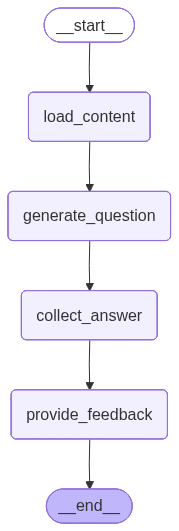

In [4]:
from IPython.display import Image, display

# Create workflow
workflow = create_multimodal_qa_workflow()

# Get graph object
graph = workflow.get_graph(xray=True)  # xray=True gives you full detail

# Render as PNG Mermaid diagram
png_data = graph.draw_mermaid_png()

# Show in notebook
display(Image(png_data))
